In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import warnings
warnings.filterwarnings('ignore')


# Load the data

In [82]:
web_visits = pd.read_csv("/Users/shaul/Downloads/data/web_visits.csv")
app_usage = pd.read_csv("/Users/shaul/Downloads/data/app_usage.csv")
claims = pd.read_csv("/Users/shaul/Downloads/data/claims.csv")
churn_labels = pd.read_csv("/Users/shaul/Downloads/data/churn_labels.csv")

# EDA

### First I like seeing the target distribution mainly for class imbalance purpose

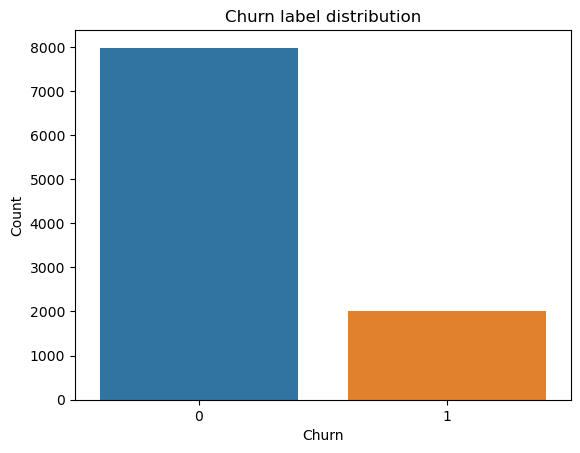

In [12]:
sns.countplot(data=churn_labels, x="churn")
plt.title("Churn label distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

#### So around 25% of the target have positive churn. This is not so extreme imbalnace but we will have to address it...

#### Missing values?

In [23]:
web_visits.info(), app_usage.info(), claims.info(), churn_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259340 entries, 0 to 259339
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   member_id    259340 non-null  int64 
 1   url          259340 non-null  object
 2   title        259340 non-null  object
 3   description  259340 non-null  object
 4   timestamp    259340 non-null  object
dtypes: int64(1), object(4)
memory usage: 9.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97789 entries, 0 to 97788
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   member_id   97789 non-null  int64 
 1   event_type  97789 non-null  object
 2   timestamp   97789 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64576 entries, 0 to 64575
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          -------------- 

(None, None, None, None)

#### It seems there are no missing values - good for me :)

#### Now let's see the distribution of the num of visits per user

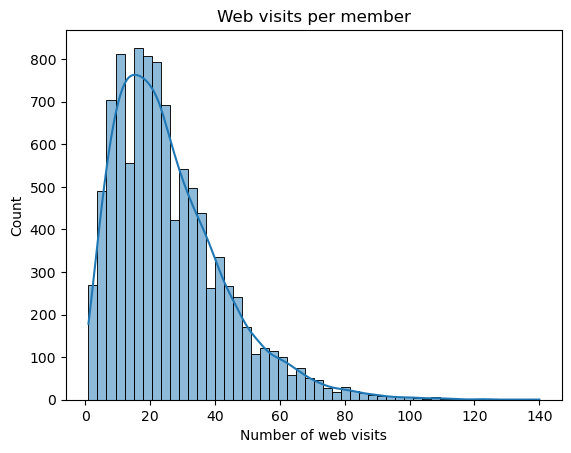

In [11]:
web_per_user = web_visits.groupby("member_id").size()
sns.histplot(web_per_user, bins=50, kde=True)
plt.title("Web visits per member")
plt.xlabel("Number of web visits")
plt.show()

#### It is a right skewed distribution as one would have expected...

#### Let's do the same for app events

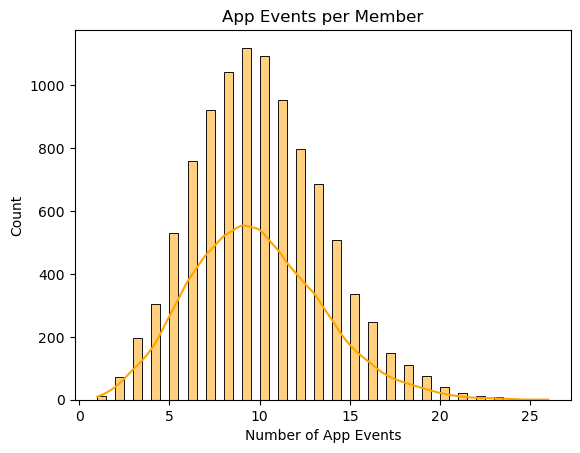

In [13]:
app_per_user = app_usage.groupby("member_id").size()
sns.histplot(app_per_user, bins=50, kde=True, color="orange")
plt.title("App Events per Member")
plt.xlabel("Number of App Events")
plt.show()

#### Now, what abou the icd-codes. Let's see what the top common 10.

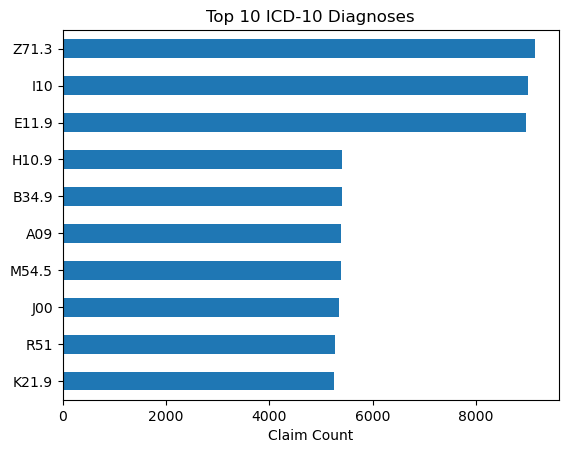

In [16]:
top_icds = claims["icd_code"].value_counts().head(10)
top_icds.plot(kind="barh")
plt.title("Top 10 ICD-10 Diagnoses")
plt.xlabel("Claim Count")
plt.gca().invert_yaxis()
plt.show()

#### We see that our 3 relevant icd codes are at the top.

#### Finally I would like to see if there are some trends in the Signups over time...

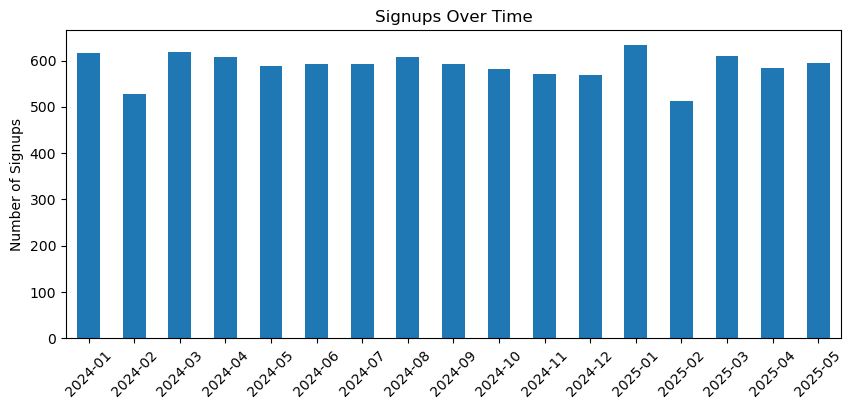

In [19]:
churn_labels["signup_date"] = pd.to_datetime(churn_labels["signup_date"])
churn_labels["signup_month"] = churn_labels["signup_date"].dt.to_period("M")
churn_labels["signup_month"].value_counts().sort_index().plot(kind="bar", figsize=(10,4))
plt.title("Signups Over Time")
plt.ylabel("Number of Signups")
plt.xticks(rotation=45)
plt.show()

#### Februaries are slighly weak months...

# Feature engineering

In [95]:
def aggregate_all_features(labels_df, web_df, app_df, claims_df):
   
    # conveert to datetime
    web_df["timestamp"] = pd.to_datetime(web_df["timestamp"])
    app_df["timestamp"] = pd.to_datetime(app_df["timestamp"])
    labels_df["signup_date"] = pd.to_datetime(labels_df["signup_date"])

    # basic counts to measure engagement
    web_agg = web_df.groupby("member_id")["url"].count().reset_index(name="web_visits")
    app_agg = app_df.groupby("member_id")["event_type"].count().reset_index(name="app_events")
    claim_agg = claims_df.groupby("member_id")["icd_code"].nunique().reset_index(name="claim_count")

    # last interaction dates to help us later
    last_web = web_df.groupby("member_id")["timestamp"].max().reset_index(name="last_web_ts")
    last_app = app_df.groupby("member_id")["timestamp"].max().reset_index(name="last_app_ts")

    # add days_web_since_signup (#days from signup till last interaction from web/app)
    signup_dates = labels_df[["member_id", "signup_date"]].copy()
    
    last_web = last_web.merge(signup_dates, on="member_id", how="left")
    last_web["days_web_since_signup"] = (last_web["last_web_ts"] - last_web["signup_date"]).dt.days
    last_web = last_web[["member_id", "days_web_since_signup"]]

    last_app = last_app.merge(signup_dates, on="member_id", how="left")
    last_app["days_app_since_signup"] = (last_app["last_app_ts"] - last_app["signup_date"]).dt.days
    last_app = last_app[["member_id", "days_app_since_signup"]]

    # health URL ratio from web_visits -> rational:
    web_df["is_health"] = web_df["url"].str.contains("health.wellco", na=False)
    web_health = web_df.groupby("member_id")["is_health"].mean().reset_index(name="visited_health_url_ratio")

    # merge all parts
    agg_df = web_agg.merge(app_agg, on="member_id", how="outer") \
                    .merge(claim_agg, on="member_id", how="outer") \
                    .merge(last_web, on="member_id", how="outer") \
                    .merge(last_app, on="member_id", how="outer") \
                    .merge(web_health, on="member_id", how="outer") \
                    .fillna(0)

    # last feature: average events per day -> the lower the avg the higher the churn
    agg_df["average_events_per_day"] = agg_df.apply(
        lambda row: row["app_events"] / row["days_app_since_signup"] if row["days_app_since_signup"] > 0 else 0, axis=1
    )

    return agg_df


In [96]:
def merge_features(labels_df, web_df, app_df, claims_df):
    
    aggregated = aggregate_all_features(labels_df, web_df, app_df, claims_df)
    features_df = labels_df.merge(aggregated, on="member_id", how="left")
    features_df = prepare_icd_flags(claims_df, features_df)
    return features_df.fillna(0)

df = merge_features(churn_labels, web_visits, app_usage, claims)

In [97]:
df.head()

,member_id,signup_date,churn,outreach,web_visits,app_events,claim_count,days_web_since_signup,days_app_since_signup,visited_health_url_ratio,average_events_per_day,has_diabetes,has_hypertension,has_dietary
0,1,2024-04-12,0,0,3.0,6.0,5.0,458.0,458.0,0.666667,0.013100,True,True,True
1,2,2025-03-11,0,0,9.0,10.0,5.0,122.0,125.0,0.222222,0.080000,True,True,True
2,3,2024-09-27,0,0,52.0,9.0,3.0,290.0,288.0,0.115385,0.031250,True,False,False
3,4,2024-04-16,1,0,15.0,10.0,3.0,453.0,453.0,0.066667,0.022075,False,True,False
4,5,2024-03-12,0,1,11.0,10.0,5.0,488.0,488.0,0.000000,0.020492,True,True,True


# Model training

#### Prepare X, y matrices and select the coloumns to train on.

In [99]:
X = df[["web_visits", "app_events", "claim_count",
    "has_diabetes", "has_hypertension", "has_dietary",
       "days_web_since_signup", "days_app_since_signup",
       "visited_health_url_ratio", "average_events_per_day"]].astype(float)

y = df["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)

# Since this is a classification model, I would like to compare 3 common but very different models.

In [118]:
# setting the params for each model for the grid search
models = {
    "Logistic Regression": {
        "model": LogisticRegression(class_weight="balanced", max_iter=2000),
        "params": {"clf__C": [0.1, 1.0, 1.5]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight="balanced", random_state=42),
        "params": {"clf__n_estimators": [500, 1000], "clf__max_depth": [3, 4]}
    },
    "XGBoost": {
        "model": XGBClassifier(scale_pos_weight=4, eval_metric="auc", random_state=42),
        "params": {"clf__n_estimators": [500, 1000], "clf__max_depth": [3, 4]}
    }
}

# cross-validation with StratifiedKFold to save target ratio
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
best_params = {}  # store best params for each model

# run grid search + CV per model
for name, config in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),   # standardizing numeric cols
        ("clf", config["model"])
    ])
    
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=config["params"],
        cv=cv,
        scoring=["roc_auc", "f1", "precision", "recall"],
        refit="roc_auc",
        return_train_score=False
    )
    
    grid.fit(X_train, y_train)
    best_params[name] = grid.best_params_  # save best parameters
    
    for i in range(5):
        cv_results.append({
            "model": name,
            "roc_auc": grid.cv_results_[f"split{i}_test_roc_auc"][grid.best_index_],
            "f1": grid.cv_results_[f"split{i}_test_f1"][grid.best_index_],
            "precision": grid.cv_results_[f"split{i}_test_precision"][grid.best_index_],
            "recall": grid.cv_results_[f"split{i}_test_recall"][grid.best_index_]
        })

# summarize results
cv_df = pd.DataFrame(cv_results)

# Results

In [119]:
# print best params
print("Best Hyperparameters per model:\n")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}\n")

Best Hyperparameters per model:

Logistic Regression: {'clf__C': 1.5}

Random Forest: {'clf__max_depth': 4, 'clf__n_estimators': 1000}

XGBoost: {'clf__max_depth': 3, 'clf__n_estimators': 500}



In [120]:
# show average results
results_df = cv_df.groupby("model").mean().round(3).reset_index()
print("Model Comparison (mean of 5 folds):\n")
print(results_df)

Model Comparison (mean of 5 folds):

                 model  roc_auc     f1  precision  recall
0  Logistic Regression    0.623  0.364      0.266   0.578
1        Random Forest    0.618  0.354      0.276   0.496
2              XGBoost    0.573  0.303      0.254   0.375


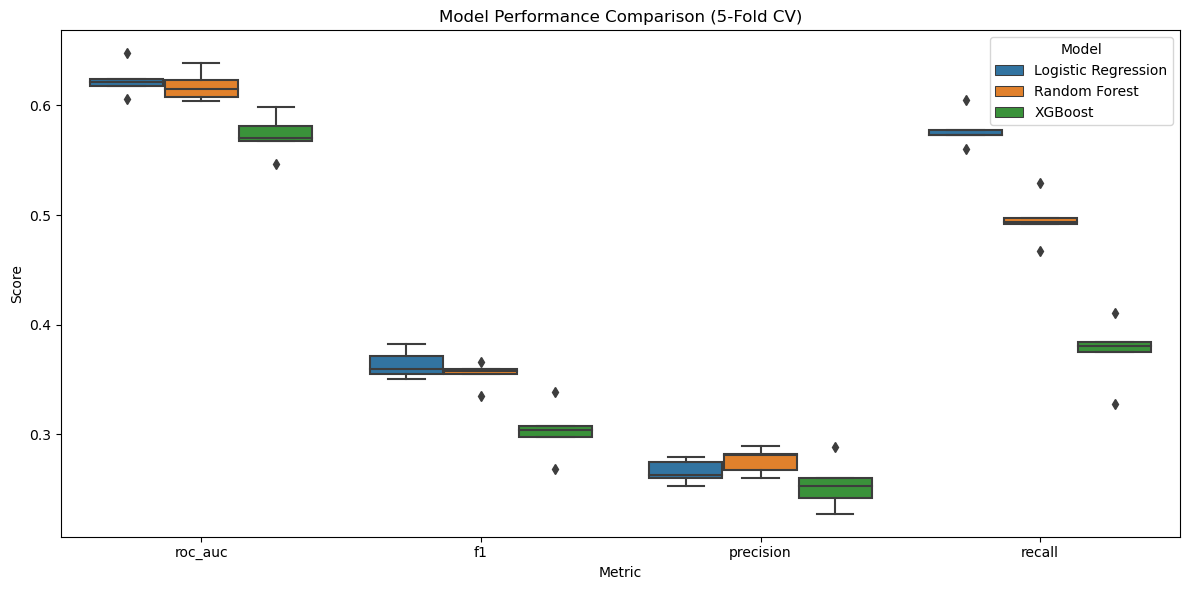

In [121]:
melted = cv_df.melt(id_vars="model", var_name="metric", value_name="score")

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted, x="metric", y="score", hue="model")
plt.title("Model Performance Comparison (5-Fold CV)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

## Let's take LR best model (C=1.5) and provide a ranked list of 'n' members for prioritized outreach.

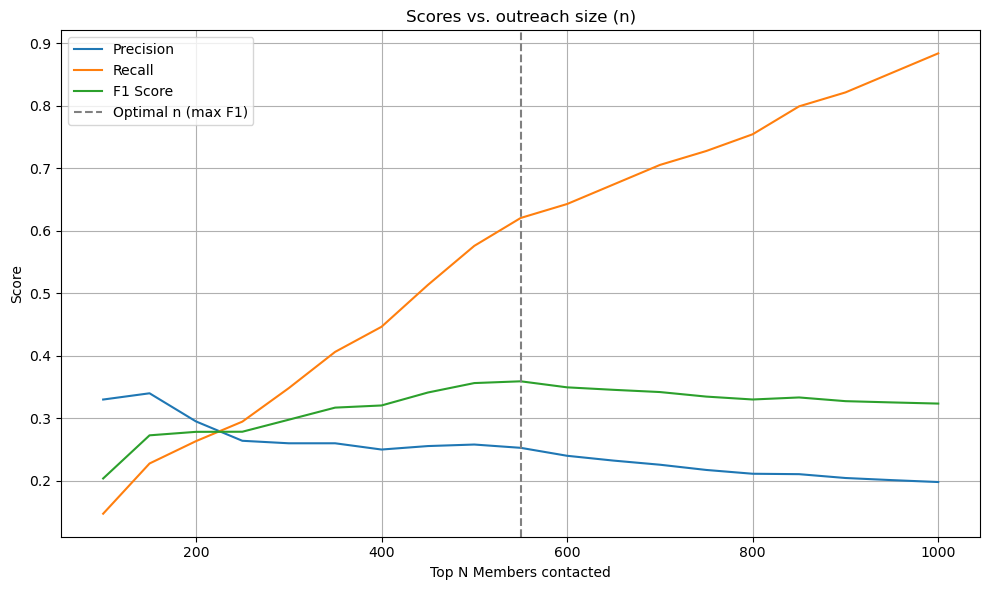

The optimal outreach size (n) for maximum F1 score: 550

Top 550 Members to contact (excluding prior outreach):



,member_id,churn_proba,rank
0,9293,0.767569,1
1,9468,0.765854,2
2,9556,0.762436,3
3,8065,0.753098,4
4,2927,0.752126,5
...,...,...,...
545,2644,0.498138,546
546,8098,0.497310,547
547,2165,0.497252,548
548,112,0.497244,549


In [135]:
# train final model
final_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(C=1.5, class_weight="balanced", max_iter=2000))
])
final_pipe.fit(X_train, y_train)

# predict churn probabilities
y_proba = final_pipe.predict_proba(X_test)[:, 1]

# match member_ids and churn labels
test_results = pd.DataFrame({
    "member_id": X_test.index,
    "true_label": y_test.values,
    "churn_proba": y_proba
}).merge(churn_labels[["member_id", "outreach"]], on="member_id", how="left")

# exclude members who already received outreach
test_results = test_results[test_results["outreach"] == 0]
test_results = test_results.sort_values("churn_proba", ascending=False).reset_index(drop=True)

# sweep for optimal outreach size
performance = []

for n in n_range:
    # mark top‑n as predicted churners
    y_pred_full = np.zeros(len(test_results), dtype=int)
    y_pred_full[:n] = 1

    y_true_full = test_results["true_label"].values

    precision = precision_score(y_true_full, y_pred_full)
    recall = recall_score(y_true_full, y_pred_full)
    f1 = f1_score(y_true_full, y_pred_full)

    performance.append({
        "n": n,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })


perf_df = pd.DataFrame(performance)


plt.figure(figsize=(10, 6))
plt.plot(perf_df["n"], perf_df["precision"], label="Precision")
plt.plot(perf_df["n"], perf_df["recall"], label="Recall")
plt.plot(perf_df["n"], perf_df["f1"], label="F1 Score")
plt.axvline(perf_df.loc[perf_df["f1"].idxmax(), "n"], color="gray", linestyle="--", label="Optimal n (max F1)")
plt.xlabel("Top N Members contacted")
plt.ylabel("Score")
plt.title("Scores vs. outreach size (n)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# select top-n
optimal_n = perf_df.loc[perf_df["f1"].idxmax(), "n"]
print(f"The optimal outreach size (n) for maximum F1 score: {optimal_n}\n")

top_n_members = test_results.head(optimal_n)[["member_id", "churn_proba"]].copy()
top_n_members["rank"] = np.arange(1, len(top_n_members) + 1)

# display ranked list
print(f"Top {optimal_n} Members to contact (excluding prior outreach):\n")
display(top_n_members)


In [138]:
# save top-n members for outreach
top_n_members.member_id.to_csv("/Users/shaul/Downloads/data/outreach.csv", index = False, header=False)